In [1]:
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms

from matplotlib import pyplot as plt



# Task 1. Build and train a network to recognize digits


## 1. Build a network model - C
Similar to the example in the tutorial, create a network with the following layers.

CNN
- A convolution layer with 10 5x5 filters
- A max pooling layer with a 2x2 window and a ReLU function applied.

- A convolution layer with 20 5x5 filters
- A dropout layer with a 0.5 dropout rate (50%)
- A max pooling layer with a 2x2 window and a ReLU function applied

RNN
- A flattening operation followed by a fully connected Linear layer with 50 nodes and a ReLU function on the output
- A final fully connected Linear layer with 10 nodes and the log_softmax function applied to the output.


The design of your network class will be in the constructorand forward method of your Network class, derived from the torch nn.Module class.

Put a diagram of your network in your report.

In [2]:

class NeuralNetwork(nn.Module):
    def __init__(self):
        
        # call the parent constructor
        super(NeuralNetwork, self).__init__()
        
        #1. CNN
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5) 
        
        # final output : 20 Channels X 4 X 4
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() # default is 0.5 or half
        
        #2. ANN
        self.fc1 = nn.Linear(in_features=320, out_features=50)
        self.fc2 = nn.Linear(50, 10)
        
        self.flatten = nn.Flatten()
     

    def forward(self, x):
        # 1. first conv, max pool, relu
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        
        # 2. 2nd conv, droptout layer, max pool, relu
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # 3. reshape tensor . why to -1, 320? this is same as flatten ?
        x = x.view(-1, 320)
        
        # 4. fully connected, relu
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

# TODO: Diagram of the network

## 2. Get the MNIST digit data set -A
The MNIST digit data consists of a training set of 60k 28x28 labeled digits and a test set of 10k 28x28 labeled digits. The data set can be imported directly from the torchvision package as torchvision.datasets.MNIST. Use the matplotlib pyplot package or OpenCV to look at the first six example digits. Look up examples that make use of the pyplot subplot method to create a grid of plots.

Include a plot of the first six example digits in your report.

In [3]:
def loadData(is_train):
    if(is_train):
        batch_num = 64
    else:
        batch_num = 1000
    
     # 1. transform the training input data to tensor and normalize it
    transform=torchvision.transforms.Compose(
                [torchvision.transforms.ToTensor(),
                 torchvision.transforms.Normalize(
                    #   normalize with mean and std
                    (0.1307,), (0.3801,)
                )
                ])
    
    
    # 2. create a data loader
    data_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(
            'mnist',
            train=is_train,
            download=True,
            transform=transform),
        batch_size=batch_num,
        shuffle=False)

    # Enumerate on test loader will give me batch index 
    # the train loader itself returning the images(example_data) and the label for it (example_target)
    return data_loader


In [4]:
def plot_sample_MNIST(data_loader) :
    figure = plt.figure(figsize=(8, 8))
    
    # get the X and y
    examples = enumerate(data_loader)
    batch_idx, (sample_data, sample_targets) = next(examples)
    print("train_data shape:", sample_data.shape)
    
    # plot the first 6 sample
    fig = plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.tight_layout()
        plt.imshow(sample_data[i][0], cmap="gray", interpolation="none")
        plt.title("Ground truth: %d" %(sample_targets[i]))
        plt.xticks([])
                  
    plt.show()

## 3. Train test and save the network - D, E

Train the model for five epochs, one epoch at a time, 
evaluating the model on both the training and test sets after each epoch. 

One Epoch is when an ENTIRE dataset is passed forward and backward through the neural network only ONCE. 

Since one epoch is too big to feed to the computer at once we divide it in several smaller batches.

Pick a batch size of your choice. 
Make a plot

In [5]:
def train_network(network, train_loader, epoch_num):
    # 1. train mode
    network.train()
    
    # result to be plot
    train_losses = []
    train_counter = []
    
    # For each batch
    for batch_idx, (data, target) in enumerate(train_loader):
        # 2. Manually set the gradients to zero using optimizer.zero_grad() since PyTorch by default accumulates gradients.
        # use gradient descent
        learning_rate = 0.1
        momentum = 0.5
        optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                              momentum=momentum)

        optimizer.zero_grad()
        output = network(data)

        # 3. compute a negative log-likelihodd (nll) loss between the output and the ground truth label
        loss = F.nll_loss(output, target)
        loss.backward()

        # 4. The backward() call we now collect a new set of gradients
        # which we propagate back into each of the network's parameters using optimizer.step()
        optimizer.step()

        # 5. what is log_interval?
        print_interval = 10
        if batch_idx % print_interval == 0:
            # - print
            print('Train Epoch: {}, batch index:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch_num,
                batch_idx,
                batch_idx * len(data),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
            # - append result per epoch to plot
            train_losses.append(loss.item())
            train_counter.append( # number of samples the model has seen
                (batch_idx*64) + ((epoch_num-1) * len(train_loader.dataset))
            )

            # - save network and optimizer
            torch.save(network.state_dict(), 'results/model.pth')
            torch.save(optimizer.state_dict(), 'results/optimizer.pth')
            
    # return the error value for each batch and the number of samples
    return train_counter, train_losses
            

In [6]:
def test_network(network, test_loader):
    network.eval()
    test_loss = 0
    correct_count = 0

    with torch.no_grad(): # disable gradient calculation

        # 1. run the test
        for data, target in test_loader:
            output = network(data)
            # get error
            test_loss += F.nll_loss(output, target, size_average=False).item()

            # get prediction
            pred = output.data.max(1, keepdim=True)[1]

            #get number of correct prediction per 1000 
            correct_count += pred.eq(target.data.view_as(pred)).sum()

        # 2. get error
        test_loss /= len(test_loader.dataset)

        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct_count, len(test_loader.dataset),
            100. * correct_count / len(test_loader.dataset)))

    return test_loss

In [7]:
def plot_result(train_counter, train_losses, test_counter, test_losses):
    plt.figure(figsize=(10,10))
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')

In [8]:
def main(argv):
    # set the device
    device = "cuda" if torch.cuda.is_available() else "cpu"


    # 1. make network reproducible
    torch.manual_seed(42)
    torch.backends.cudnn.enabled = False

    # 2. load and plot data
    train_loader = loadData(is_train=True)
    test_loader = loadData(is_train=False)
    plot_sample_MNIST(train_loader)
    plot_sample_MNIST(test_loader)

    # 3. create network model
    network = NeuralNetwork()

    # 4. train and test network model
    epoch_num = 5

    # create list to plot the number of training samples on x axis, and the scores
    train_counter_per_epoch = []
    train_counter = []
    train_losses = []

    test_losses = []
    test_counter = [i * len(train_loader.dataset) for i in range(epoch_num + 1)]
    test_losses.append(0)

    for epoch in range(1, epoch_num + 1):
        # - train and get counter and loss list
        train_counter_per_epoch, train_loss_per_epoch = train_network(
            network, train_loader, epoch)

        train_counter.append(train_counter_per_epoch)
        train_losses.append(train_loss_per_epoch)

        # - test
        test_losses.append(test_network(network, test_loader))


    # 5. flatten the two arrays
    # for all the sublist in regular list,
    # get all the sub item in sublist
    flat_train_counter = [single_item for sublist in train_counter
                        for single_item in sublist]


    flat_train_losses = [single_item for sublist in train_losses
                        for single_item in sublist]
    
    # 6. plot result
    print("test counter shape:", len(test_counter), "value:", test_counter)
    print("test loss shape:", len(test_losses), "value:", test_losses)

    print("train counter shape:", len(flat_train_counter))
    print("train loss shape:", len(flat_train_losses))
    plot_result(flat_train_counter, flat_train_losses, test_counter, test_losses)

    
    

train_data shape: torch.Size([64, 1, 28, 28])


<Figure size 576x576 with 0 Axes>

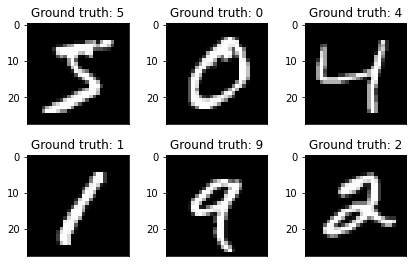

train_data shape: torch.Size([1000, 1, 28, 28])


<Figure size 576x576 with 0 Axes>

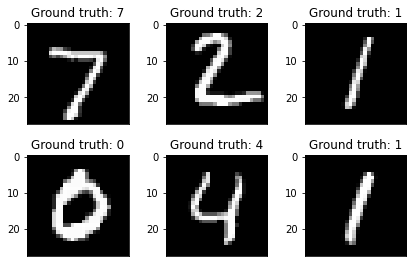

Train Epoch: 1, batch index:0 [0/60000 (0%)]	Loss: 2.273105


/var/folders/76/26vt73dx7psbzwyygdm5wtt40000gn/T/ipykernel_10411/3549720080.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1, batch index:10 [640/60000 (1%)]	Loss: 2.285099
Train Epoch: 1, batch index:20 [1280/60000 (2%)]	Loss: 2.158334
Train Epoch: 1, batch index:30 [1920/60000 (3%)]	Loss: 1.983409
Train Epoch: 1, batch index:40 [2560/60000 (4%)]	Loss: 1.653252
Train Epoch: 1, batch index:50 [3200/60000 (5%)]	Loss: 1.566040
Train Epoch: 1, batch index:60 [3840/60000 (6%)]	Loss: 1.212008
Train Epoch: 1, batch index:70 [4480/60000 (7%)]	Loss: 0.958365
Train Epoch: 1, batch index:80 [5120/60000 (9%)]	Loss: 1.269623
Train Epoch: 1, batch index:90 [5760/60000 (10%)]	Loss: 1.047296
Train Epoch: 1, batch index:100 [6400/60000 (11%)]	Loss: 0.771251
Train Epoch: 1, batch index:110 [7040/60000 (12%)]	Loss: 0.707297
Train Epoch: 1, batch index:120 [7680/60000 (13%)]	Loss: 0.985618
Train Epoch: 1, batch index:130 [8320/60000 (14%)]	Loss: 0.744026
Train Epoch: 1, batch index:140 [8960/60000 (15%)]	Loss: 0.506329
Train Epoch: 1, batch index:150 [9600/60000 (16%)]	Loss: 0.654076
Train Epoch: 1, batch index:

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1038, Accuracy: 9683/10000 (97%)

Train Epoch: 2, batch index:0 [0/60000 (0%)]	Loss: 0.280047
Train Epoch: 2, batch index:10 [640/60000 (1%)]	Loss: 0.139082
Train Epoch: 2, batch index:20 [1280/60000 (2%)]	Loss: 0.182608
Train Epoch: 2, batch index:30 [1920/60000 (3%)]	Loss: 0.194861
Train Epoch: 2, batch index:40 [2560/60000 (4%)]	Loss: 0.175615
Train Epoch: 2, batch index:50 [3200/60000 (5%)]	Loss: 0.198451
Train Epoch: 2, batch index:60 [3840/60000 (6%)]	Loss: 0.128737
Train Epoch: 2, batch index:70 [4480/60000 (7%)]	Loss: 0.113121
Train Epoch: 2, batch index:80 [5120/60000 (9%)]	Loss: 0.430448
Train Epoch: 2, batch index:90 [5760/60000 (10%)]	Loss: 0.297093
Train Epoch: 2, batch index:100 [6400/60000 (11%)]	Loss: 0.343260
Train Epoch: 2, batch index:110 [7040/60000 (12%)]	Loss: 0.287952
Train Epoch: 2, batch index:120 [7680/60000 (13%)]	Loss: 0.294868
Train Epoch: 2, batch index:130 [8320/60000 (14%)]	Loss: 0.250685
Train Epoch: 2, batch index:140 [8960/6000

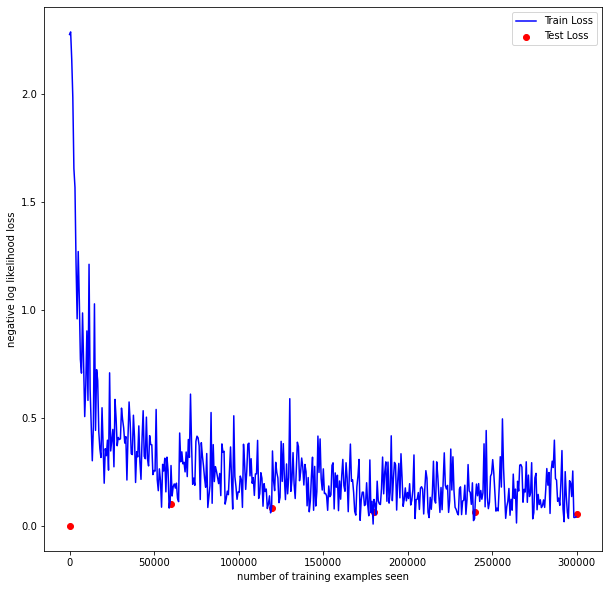

In [9]:
if __name__ == "__main__":
    main(sys.argv)

In [ ]:
# Question. how to draw the first one ?